In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import numba

from src import GWParameters, GWModel, save_sim_list, load_sim_list

matplotlib.style.use('seaborn-v0_8-darkgrid')
FIG_HEIGHT = 12

In [2]:
NCaRU_sim = 500

XKr = np.array([0.999503, 4.13720e-4, 7.27568e-5, 8.73984e-6, 1.36159e-6])
XKv14 = np.array([0.953060, 0.0253906, 2.53848e-4, 1.12796e-6, 1.87950e-9, 0.0151370, 0.00517622, 8.96600e-4, 8.17569e-5, 2.24032e-6])
XKv43 = np.array([0.722328, 0.101971, 0.00539932, 1.27081e-4, 1.82742e-6, 0.152769, 0.00962328, 0.00439043, 0.00195348, 0.00143629])

CaSS = np.ones((NCaRU_sim, 4)) * 1.45370e-4
CaJSR = np.ones(NCaRU_sim) * 0.908408
LCC = np.random.choice([1, 2, 7], p=[0.958, 0.038, 0.004], size=(NCaRU_sim, 4))
LCC_inactivation = np.random.choice([0, 1], p=[0.0575, 0.9425], size=(NCaRU_sim, 4))
ClCh = np.random.choice([0, 1], p=[0.998, 0.002], size=(NCaRU_sim, 4))
RyR = np.zeros((NCaRU_sim, 4, 6), dtype=np.int32)
for i in range(NCaRU_sim):
    for j in range(4):
        for k in range(5):
            idx = np.random.choice([0, 4, 5], p=[0.609, 0.5*0.391, 0.5*0.391])
            RyR[i, j, idx] += 1


init_state = {
    "V": -91.382,
    "Nai": 10.0,
    "Ki": 131.84,
    "Cai": 1.45273e-4,
    "CaNSR": 0.908882,
    "CaLTRPN": 8.9282e-3,
    "CaHTRPN": 0.137617,
    "m": 5.33837e-4,
    "h": 0.996345,
    "j": 0.997315,
    "xKs": 2.04171e-4,
    "XKr": XKr,
    "XKv14": XKv14,
    "XKv43": XKv43,

    "CaSS": CaSS,
    "CaJSR": CaJSR,
    "LCC": LCC,
    "LCC_inactivation": LCC_inactivation,
    "RyR": RyR,
    "ClCh": ClCh
}

In [3]:
NCaRU_sim = 500
#NCaRU_sim = 1250 # 10% of NCaRU = 12500
params = GWParameters(NCaRU_sim=NCaRU_sim) # Create parameters object using default values
Istim = lambda t: 35 if t < 2 else 0 # Stimulus function

model = GWModel(parameters=params, stimulus_fn=Istim, init_state=init_state) # Convenience wrapper around C++ function

In [77]:
step_size = 1e-3 # Pick a small step size for accuracy and to reduce bias from parallelising the SSA
num_steps = 1_000_000 # Simulate the AP for 500ms
record_every = 10 # Record the state every 500 steps (0.5 ms)

In [78]:
%%time
sim = model.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every)

CPU times: user 7min 34s, sys: 8.45 s, total: 7min 42s
Wall time: 29.5 s


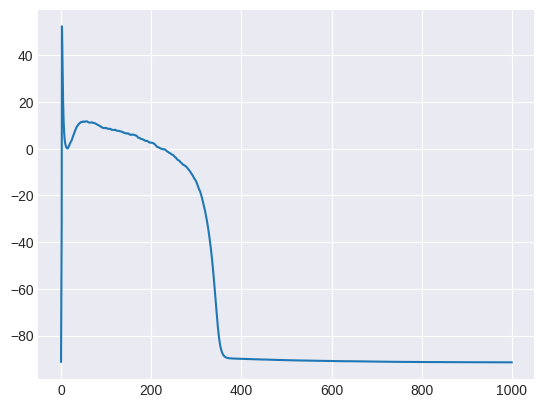

In [79]:
plt.plot(sim.t, sim.V)
plt.show()

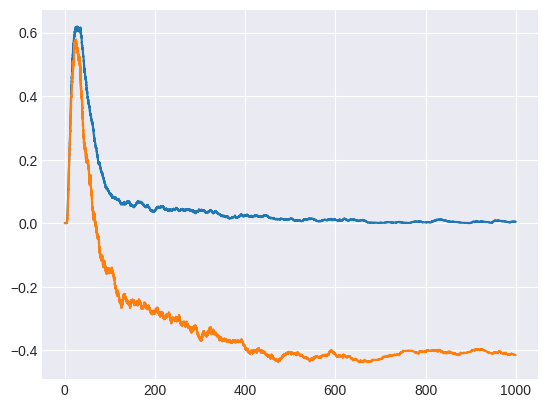

In [80]:
plt.plot(sim.t, (sim.RyR[..., 2] + sim.RyR[...,3]).mean(axis=(1,2)))
plt.plot(sim.t, sim.RyR_open_int[:,0])
plt.show()

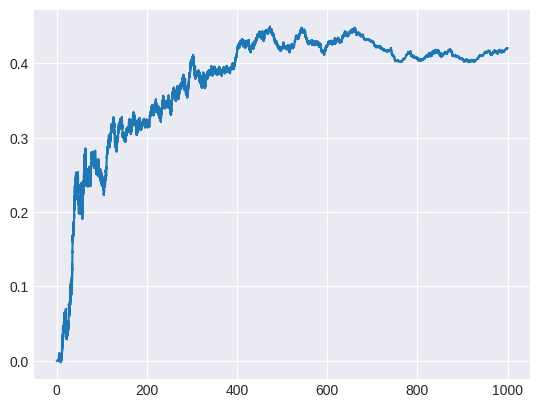

In [81]:
plt.plot(sim.t, sim.RyR_open_martingale[:, 0])
plt.show()

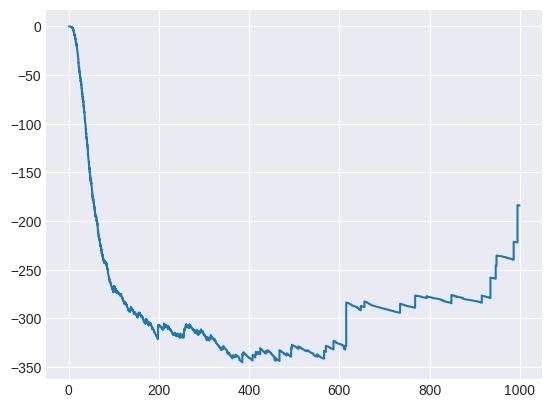

In [82]:
plt.plot(sim.t, sim.RyR_open_martingale_normalised[:, 0])
plt.show()

In [83]:
mgle_increments = np.zeros_like(sim.t)
mgle_n_increments = np.zeros_like(sim.t)

mgle_increments[0] = sim.RyR_open_martingale[0,0]
mgle_n_increments[0] = sim.RyR_open_martingale_normalised[0,0]

mgle_increments[1:] = sim.RyR_open_martingale[1:,0] - sim.RyR_open_martingale[:-1,0]
mgle_n_increments[1:] = sim.RyR_open_martingale_normalised[1:,0] - sim.RyR_open_martingale_normalised[:-1,0]

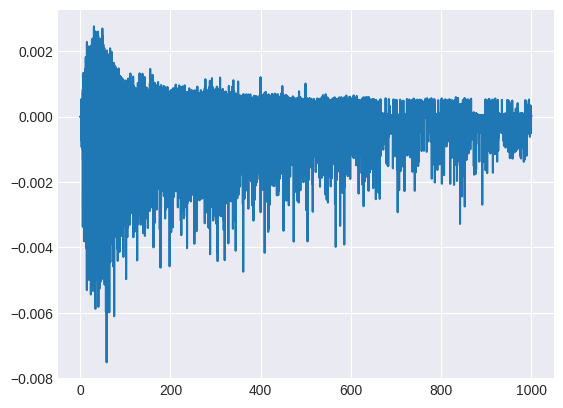

In [84]:
plt.plot(sim.t, mgle_increments)
plt.show()

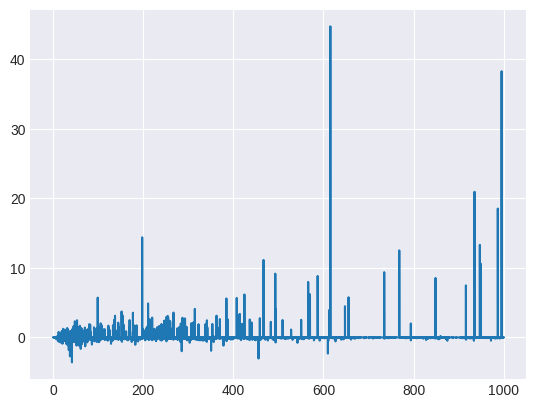

In [85]:
plt.plot(sim.t, mgle_n_increments)
plt.show()

In [86]:
np.mean(mgle_n_increments)

-0.001841164237915304

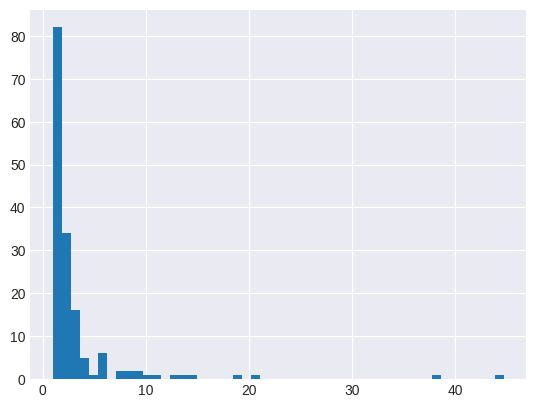

In [87]:
plt.hist(np.abs(mgle_n_increments[np.abs(mgle_n_increments) > 1]), bins=50)
plt.show()

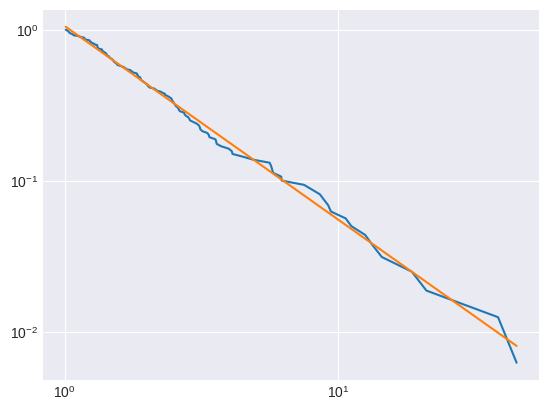

In [99]:
mgle_n_increments_thresh = np.abs(mgle_n_increments[np.abs(mgle_n_increments) > 1])
ps = np.arange(start=1, stop=mgle_n_increments_thresh.shape[0]+1) / mgle_n_increments_thresh.shape[0]

coeffs = np.polyfit(np.log(np.sort(mgle_n_increments_thresh)), np.log(ps[::-1]), 1)

plt.plot(np.sort(mgle_n_increments_thresh), ps[::-1])
plt.plot(np.sort(mgle_n_increments_thresh), np.exp(coeffs[1])*np.exp(coeffs[0]*np.log(np.sort(mgle_n_increments_thresh))))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [100]:
print(coeffs[0]-1)

-2.2810104830653044


In [90]:
jump_pos = np.where(np.abs(mgle_n_increments) > 1)[0]

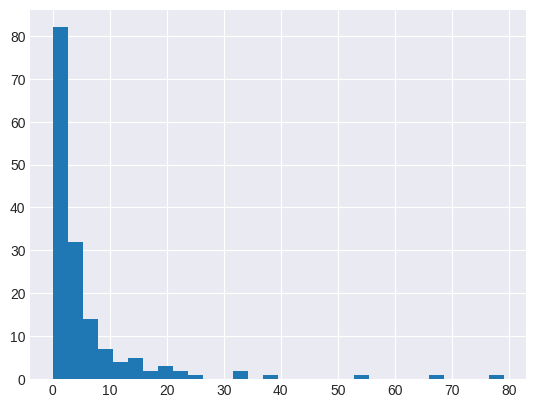

In [101]:
inter_jump_times = sim.t[jump_pos[1:]] - sim.t[jump_pos[:-1]]
plt.hist(inter_jump_times, bins=30)
plt.show()

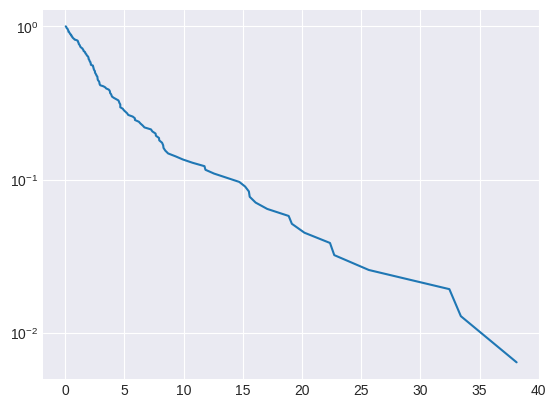

In [103]:
ps = np.arange(start=1, stop=inter_jump_times[inter_jump_times < 50].shape[0]+1) / inter_jump_times[inter_jump_times < 50].shape[0]
plt.plot(np.sort(inter_jump_times[inter_jump_times < 50]), ps[::-1])
plt.yscale('log')
plt.show()

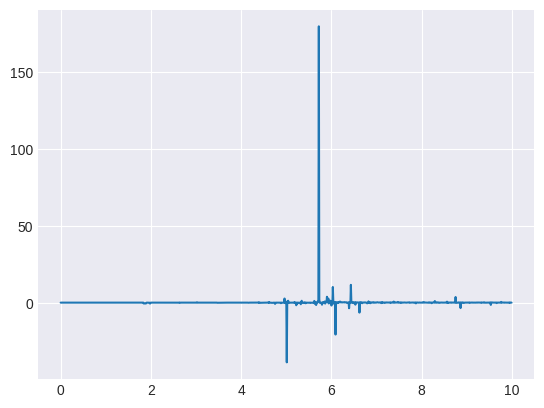

In [108]:
plt.plot(sim.t[:1000], mgle_increments[:1000] / mgle_n_increments[:1000])
plt.show()

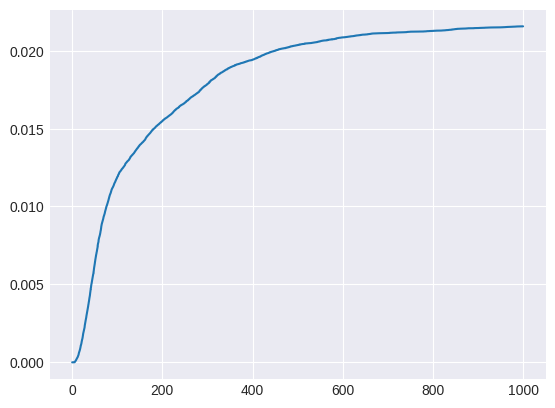

In [110]:
plt.plot(sim.t, (mgle_increments**2).cumsum())
plt.show()

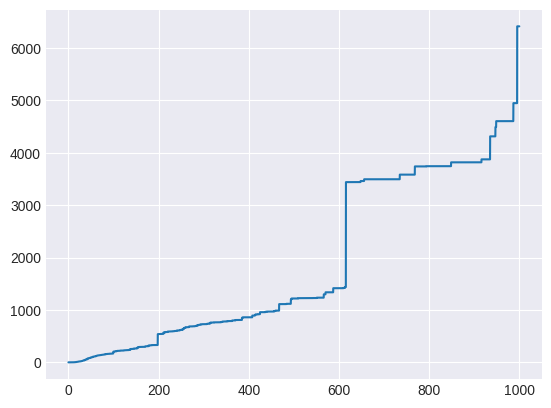

In [111]:
plt.plot(sim.t, (mgle_n_increments**2).cumsum())
plt.show()

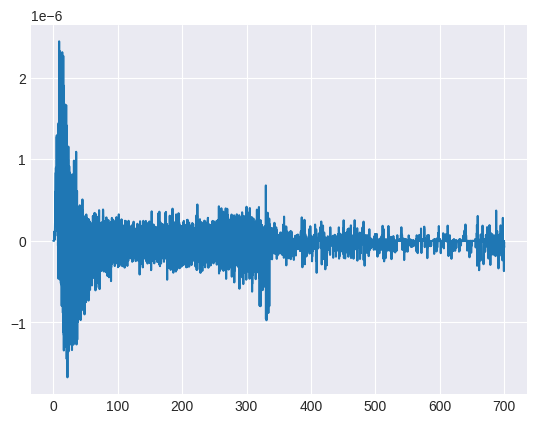

In [10]:
plt.plot(sim.t, sim.dCaSS_mean)
plt.show()

In [27]:
np.argmax(np.abs(sim.dM))

31139

In [33]:
sim.dM[31139]

0.0001727153155922645

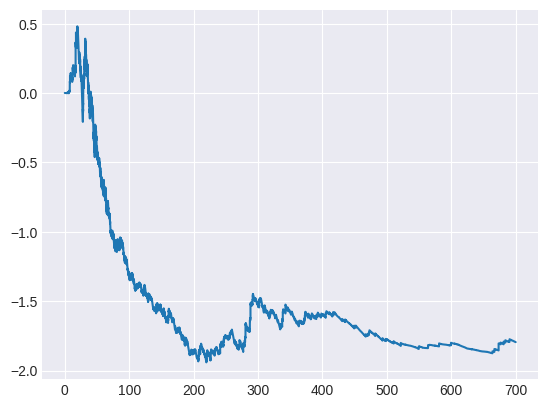

In [11]:
plt.plot(sim.t, sim.intQTXt)
plt.show()

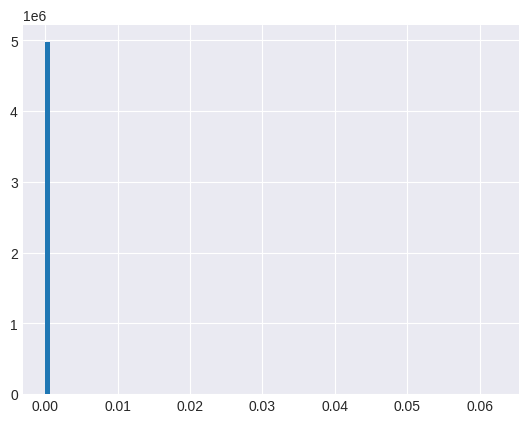

In [12]:
plt.hist(np.abs(sim.dM_normalised), bins=100)
plt.show()

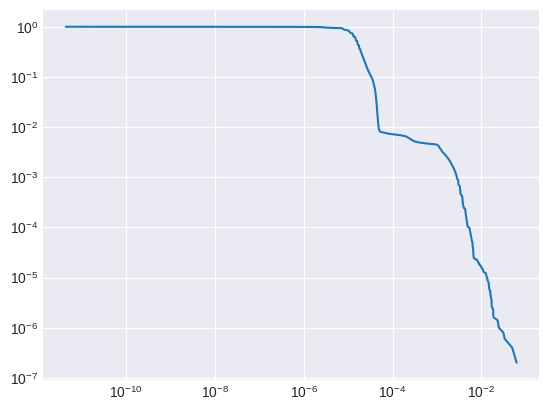

In [13]:
ps = np.arange(start=1, stop=sim.dM_normalised.shape[0]+1) / sim.dM_normalised.shape[0]
plt.plot(np.sort(np.abs(sim.dM_normalised)), ps[::-1])
plt.xscale('log')
plt.yscale('log')
plt.show()

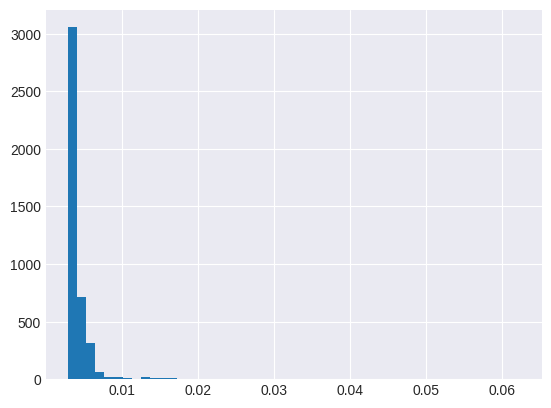

In [14]:
plt.hist(np.abs(sim.dM_normalised[np.abs(sim.dM_normalised) > 3e-3]), bins=50)
plt.show()

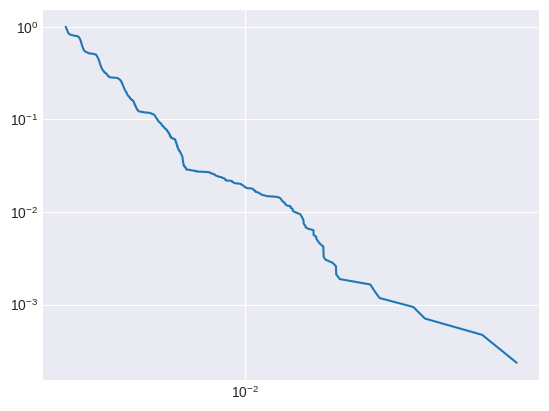

In [19]:
abv_thresh = np.abs(sim.dM_normalised[np.abs(sim.dM_normalised) > 3e-3])
ps = np.arange(start=1, stop=abv_thresh.shape[0]+1) / abv_thresh.shape[0]
plt.plot(np.sort(abv_thresh), ps[::-1])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [33]:
jump_pos = np.where(np.abs(sim.dM_normalised) > 3e-3)[0]

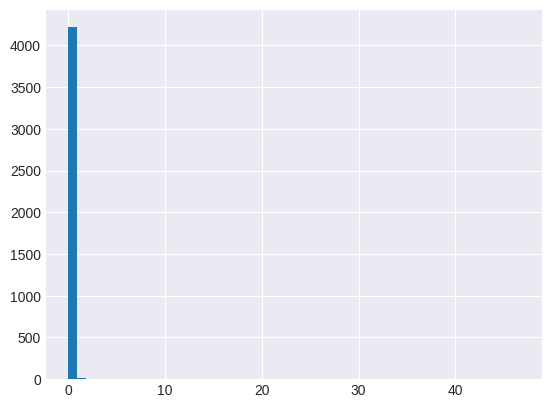

In [34]:
plt.hist(sim.t[jump_pos[1:]] - sim.t[jump_pos[:-1]], bins=50)
plt.show()

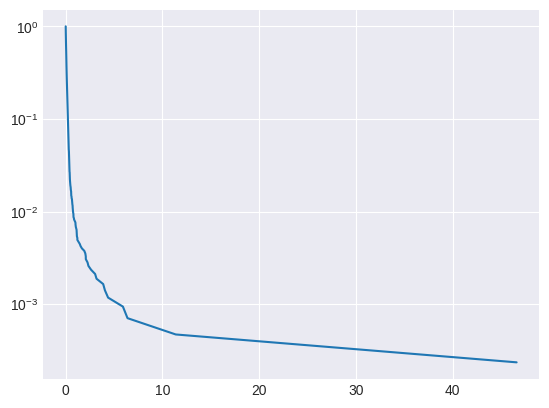

In [35]:
ps = np.arange(start=1, stop=jump_pos.shape[0]) / (jump_pos.shape[0]-1)
plt.plot(np.sort(sim.t[jump_pos[1:]] - sim.t[jump_pos[:-1]]), ps[::-1])
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [12]:
%%time
sim = model.simulate(step_size=step_size, num_steps=num_steps, record_every=100)

CPU times: user 6min 18s, sys: 10.2 s, total: 6min 28s
Wall time: 25.8 s


In [13]:
RyR_open = sim.RyR[..., 2] + sim.RyR[..., 3]

In [22]:
RyR_open_ = RyR_open[1:] - RyR_open[:-1]

In [23]:
EXY = (RyR_open_[:, :, 0]*RyR_open_[:, :, 1] + RyR_open_[:, :, 1]*RyR_open_[:, :, 2] + RyR_open_[:, :, 2]*RyR_open_[:, :, 3] + RyR_open_[..., 3]*RyR_open_[..., 0]).mean(axis=1)

In [24]:
EXEY = (RyR_open_[..., 0].mean(axis=1)*RyR_open_[..., 1].mean(axis=1) + RyR_open_[..., 1].mean(axis=1)*RyR_open_[..., 2].mean(axis=1) + RyR_open_[..., 2].mean(axis=1)*RyR_open_[..., 3].mean(axis=1)
        + RyR_open_[..., 3].mean(axis=1)*RyR_open_[..., 0].mean(axis=1))

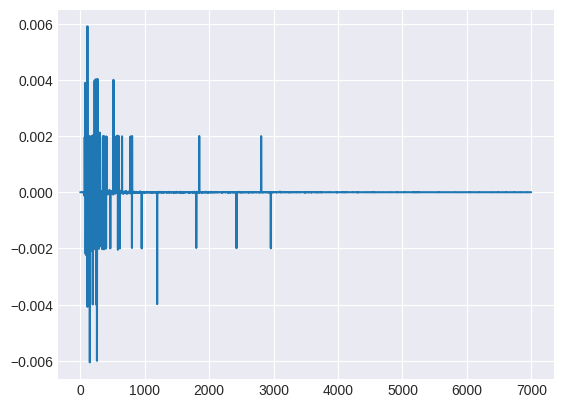

In [25]:
plt.plot(EXY - EXEY)
plt.show()

In [6]:
mgle = (sim.RyR[..., 2] + sim.RyR[..., 3]).mean(axis=(1,2)) - sim.int_QTXt

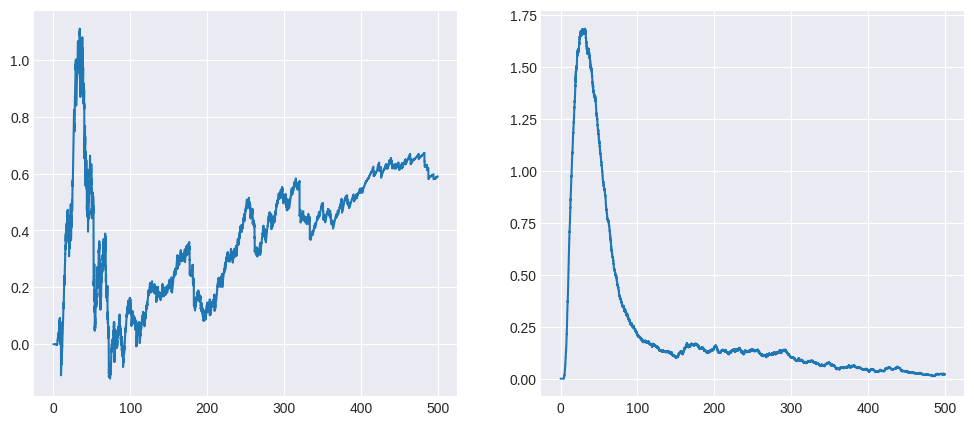

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
#for i in range(10):
#    ax[0].plot(sim[i].t, mgles[i])
#    ax[1].plot(sim[i].t, sim[i].RyR[..., 2:3].mean(axis=(1,2,3))*5)
    #ax[1].plot(sim.t, sim.int_QTXt)
ax[0].plot(sim.t, mgle)
ax[1].plot(sim.t, sim.RyR[..., 2:4].mean(axis=(1,2,3))*5)
plt.show()

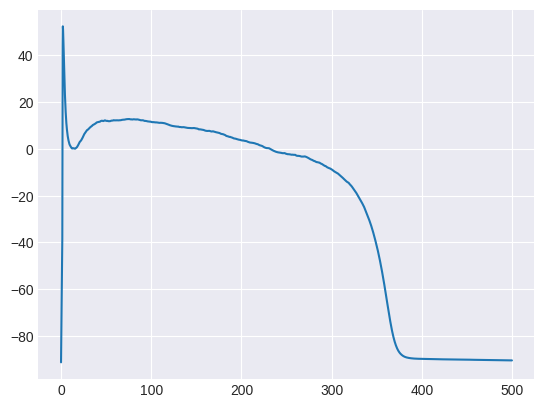

In [8]:
#for i in range(10):
#    plt.plot(sim[i].t, sim[i].V)
plt.plot(sim.t, sim.V)
plt.show()

In [9]:
#dM = np.stack([m[1:] - m[:-1] for m in mgles], axis=-1)
dM = mgle[1:] - mgle[:-1]

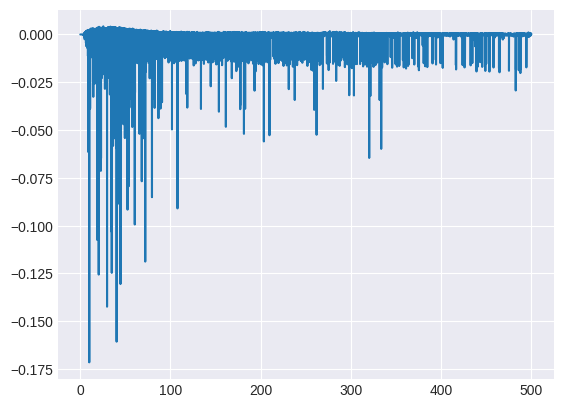

In [10]:
plt.plot(sim.t[1:], dM)
plt.show()

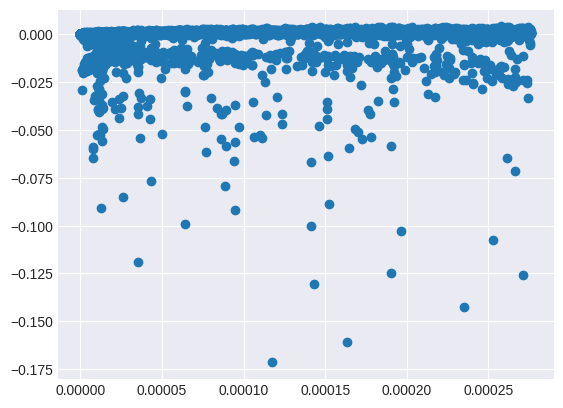

In [13]:
plt.scatter((sim.CaSS**2).mean(axis=(1,2))[:-1], dM)
plt.show()

In [14]:
def Y2Xsq(RyR, CaSS, k23):
    return k23 * (RyR[..., 1] * CaSS**2).mean(axis=(1,2))

@numba.njit
def Y5Xsq(RyR, CaSS, k54, k65, k56):
    out = np.zeros(RyR.shape[0])
    for i in range(RyR.shape[0]):
        for j in range(RyR.shape[1]):
            for k in range(4):
                if CaSS[i,j,k] > 0.000115:
                    out[i] += (RyR[i,j,k,4] + RyR[i,j,k,5]) * k54 * k65 * CaSS[i,j,k]**4 / (k56 * CaSS[i,j,k]**2 + k65)
                else:
                    out[i] += k54 * RyR[i,j,k,4] * CaSS[i,j,k]**2

    return out / (4*RyR.shape[1])

@numba.njit
def Y3(RyR, CaSS, k32, k34, k43):
    out = np.zeros(RyR.shape[0])
    for i in range(RyR.shape[0]):
        for j in range(RyR.shape[1]):
            for k in range(4):
                if CaSS[i,j,k] > 0.03685:
                    out[i] += (RyR[i,j,k,2] + RyR[i,j,k,3]) * k32 * k43 / (k34 * CaSS[i,j,k]**2 + k43)
                else:
                    out[i] += k32 * RyR[i,j,k,2]

    return out / (4*RyR.shape[1])


@numba.njit
def Y4(RyR, CaSS, k45, k34, k43):
    out = np.zeros(RyR.shape[0])
    for i in range(RyR.shape[0]):
        for j in range(RyR.shape[1]):
            for k in range(4):
                if CaSS[i,j,k] > 0.03685:
                    out[i] += (RyR[i,j,k,2] + RyR[i,j,k,3]) * k45 * k34 * CaSS[i,j,k]**2 / (k34 * CaSS[i,j,k]**2 + k43)
                else:
                    out[i] += k45 * RyR[i,j,k,3]

    return out / (4*RyR.shape[1])


def var_term(sim, params):
    return (Y2Xsq(sim.RyR, sim.CaSS, params.k32) + 
           Y5Xsq(sim.RyR, sim.CaSS, params.k54, params.k65, params.k56) +
           Y3(sim.RyR, sim.CaSS, params.k32, params.k34, params.k43) +
           Y4(sim.RyR, sim.CaSS, params.k45, params.k34, params.k43))
    

In [15]:
v_ = var_term(sim, params)

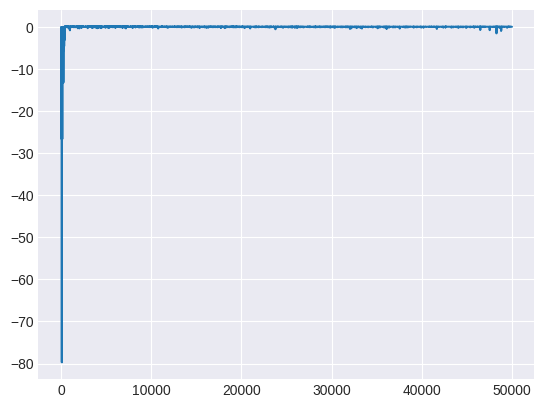

In [17]:
plt.plot(dM[10:] / np.sqrt(v_[10:-1]))
plt.show()

In [37]:
RyR_open = params.k32 * sim.RyR[..., 2] + params.k45 * sim.RyR[..., 3]

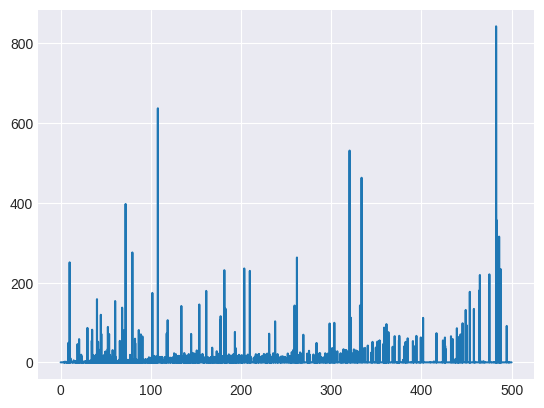

In [42]:
plt.plot(sim.t[1:], dM**2 / (sim.CaSS[:-1]**2).mean(axis=(1,2)))
plt.show()

In [45]:
jumps = dM**2 / (sim.CaSS[:-1]**2).mean(axis=(1,2))

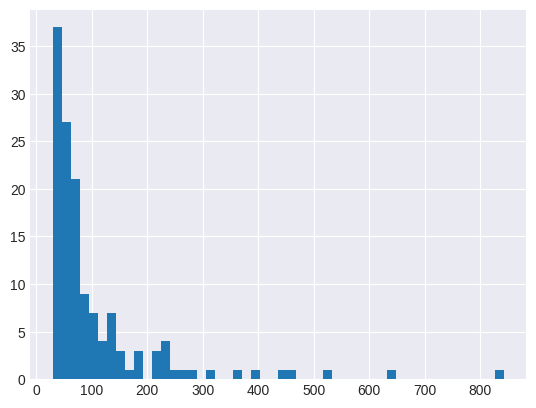

In [66]:
plt.hist(jumps[jumps > 30], bins=50)
plt.show()

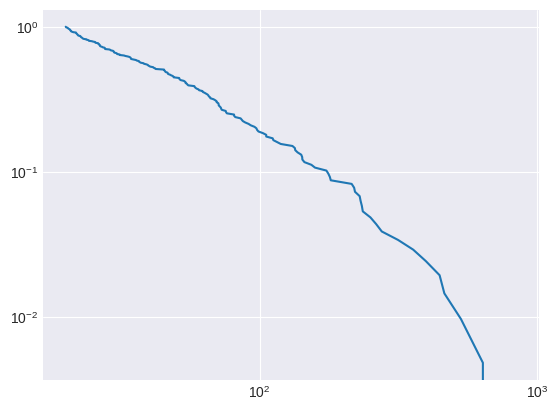

In [129]:
q = np.sort(jumps[jumps > 20])
plt.plot(q[::-1], np.linspace(0, 1, num=len(q)))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [83]:
ps_ = np.linspace(0, 1, num=len(q))
np.log(q[100]) - np.log(q[0])

0.7448418032196069

In [93]:
(np.log(ps_[205-50]) - np.log(ps_[-1])) / np.log(q[50]) - np.log(q[0])

-3.082505377818596

In [105]:
((jumps > 3) * (jumps < 20)).mean()

0.009080181603632073

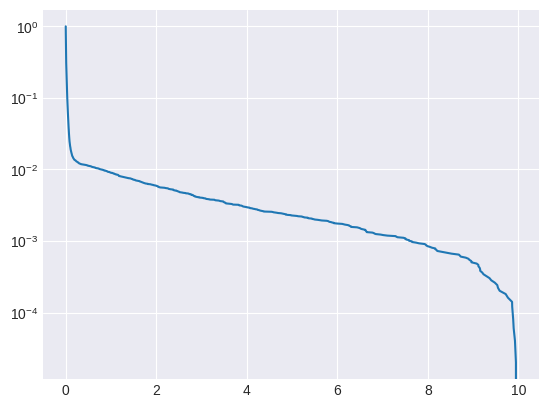

In [115]:
q_ = np.sort(jumps[(jumps < 10)])
plt.plot(q_[::-1], np.linspace(0, 1, num=len(q_)))
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [130]:
pos = np.where(jumps > 20)[0]

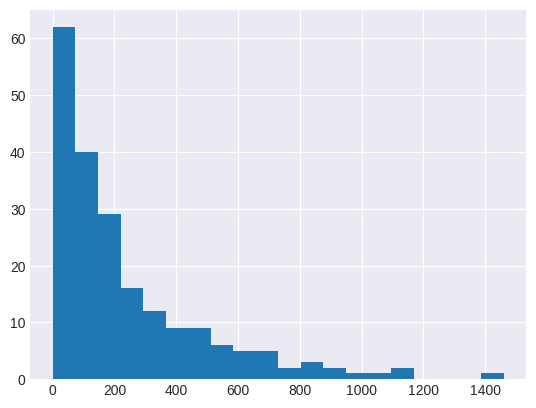

In [131]:
plt.hist(pos[1:] - pos[:-1], bins=20)
plt.show()

In [132]:
(pos[1:] - pos[:-1]).mean() / (pos[1:] - pos[:-1]).std()

0.9202433300029189

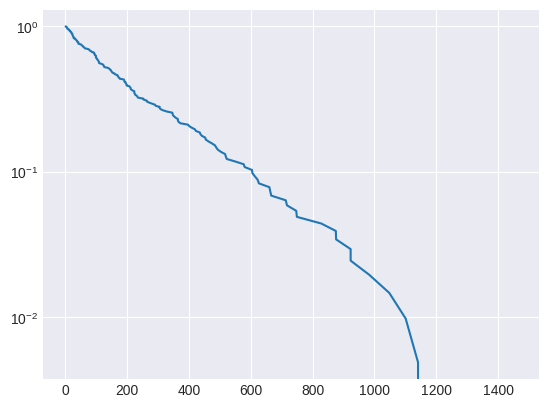

In [133]:
q_pos = np.sort(pos[1:] - pos[:-1])
plt.plot(q_pos[::-1], np.linspace(0, 1, num=len(q_pos)))
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [136]:
(dM[pos] > 0).mean()

0.0

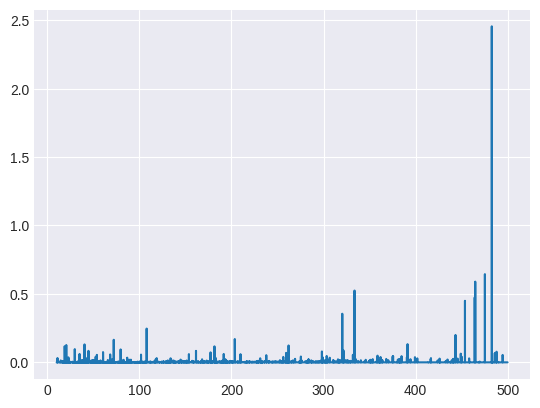

In [41]:
plt.plot(sim.t[1001:], dM[1000:]**2 / v_[1001:])
plt.show()

In [81]:
dM.mean()

-0.0002976264937910925

In [220]:
del sim

In [221]:
%%time
sim = model.simulate(step_size=step_size, num_steps=600_000, record_every=record_every)

CPU times: user 6min 15s, sys: 6.42 s, total: 6min 22s
Wall time: 24.6 s


In [222]:
mgle = (sim.RyR[..., 2] + sim.RyR[..., 3]).mean(axis=(1,2)) - sim.int_QTXt

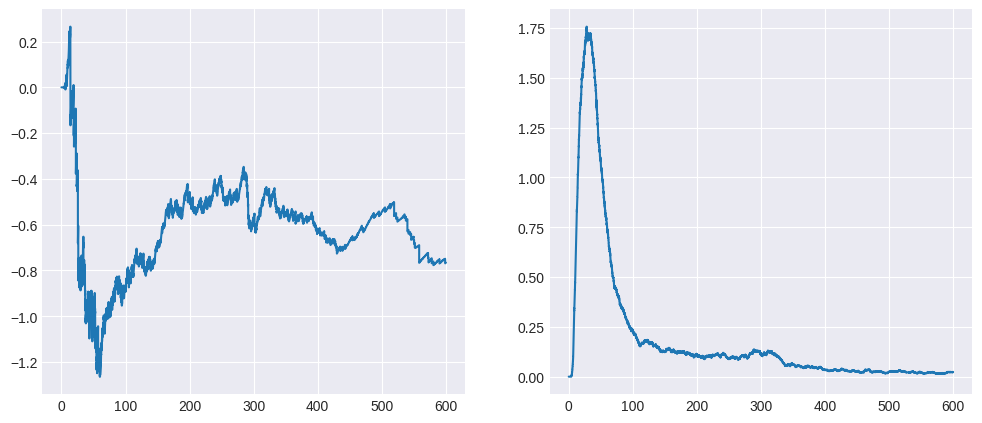

In [223]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
#for i in range(10):
#    ax[0].plot(sim[i].t, mgles[i])
#    ax[1].plot(sim[i].t, sim[i].RyR[..., 2:3].mean(axis=(1,2,3))*5)
    #ax[1].plot(sim.t, sim.int_QTXt)
ax[0].plot(sim.t, mgle)
ax[1].plot(sim.t, sim.RyR[..., 2:4].mean(axis=(1,2,3))*5)
plt.show()

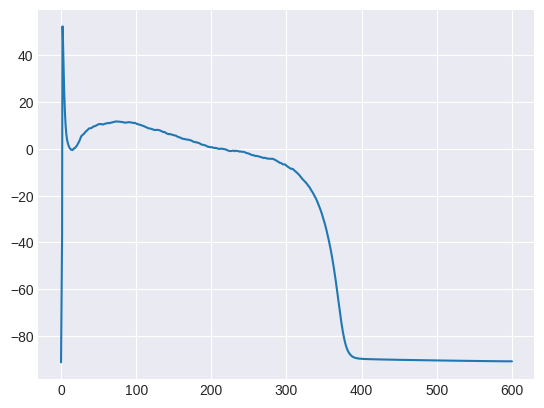

In [224]:
plt.plot(sim.t, sim.V)
plt.show()

In [225]:
dM = mgle[1:] - mgle[:-1]

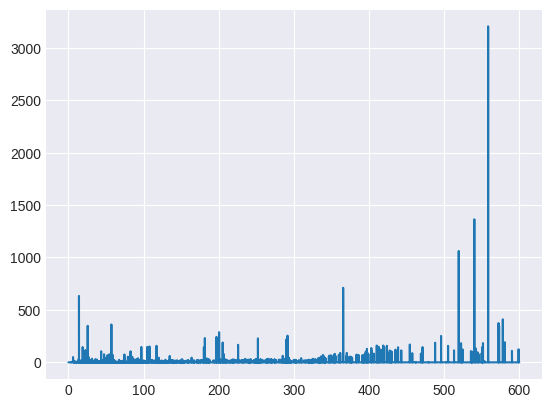

In [226]:
plt.plot(sim.t[1:], dM**2 / (sim.CaSS[:-1]**2).mean(axis=(1,2)))
plt.show()

In [227]:
jumps = dM**2 / (sim.CaSS[:-1]**2).mean(axis=(1,2))

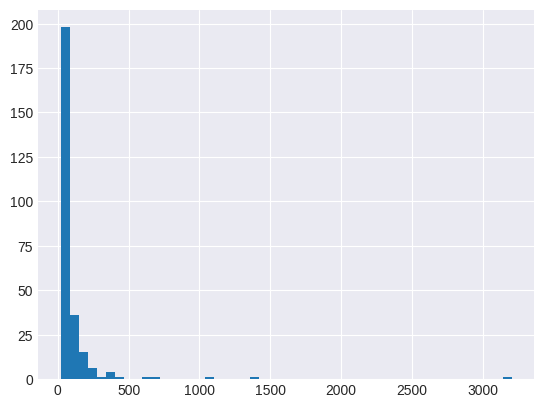

In [228]:
plt.hist(jumps[jumps > 20], bins=50)
plt.show()

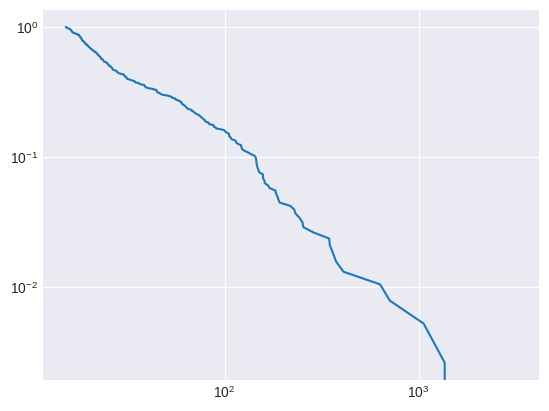

In [249]:
q = np.sort(jumps[(jumps > 15)])
plt.plot(q[::-1], np.linspace(0, 1, num=len(q)))
plt.xscale('log')
plt.yscale('log')
plt.show()

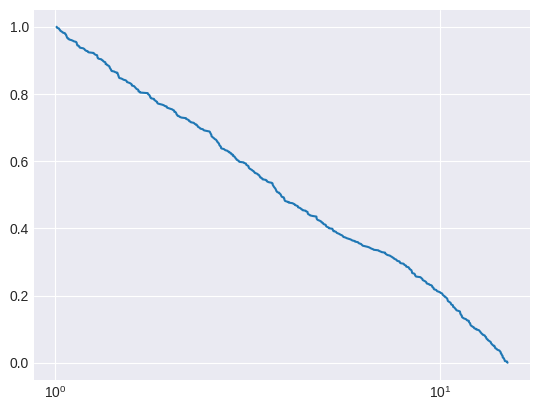

In [265]:
q = np.sort(jumps[(jumps < 15) * (jumps > 1)])
plt.plot(q[::-1], np.linspace(0, 1, num=len(q)))
plt.xscale('log')
#plt.yscale('log')
plt.show()

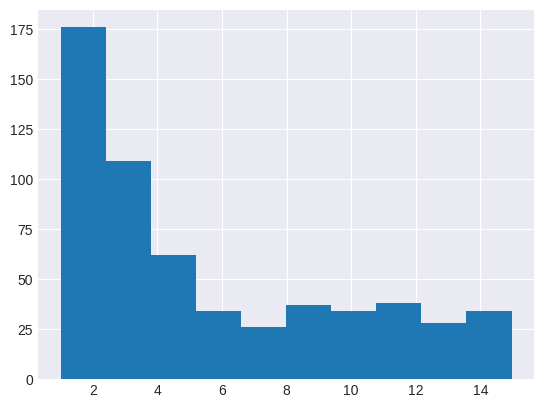

In [264]:
plt.hist(jumps[(jumps < 15) * (jumps > 1)])
plt.show()

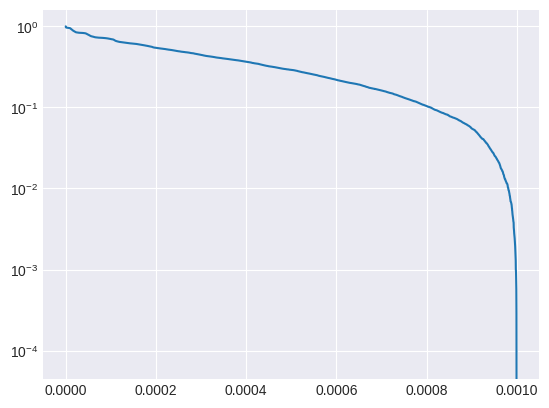

In [272]:
q = np.sort(jumps[(jumps < 1e-3)])
plt.plot(q[::-1], np.linspace(0, 1, num=len(q)))
#plt.xscale('log')
plt.yscale('log')
plt.show()

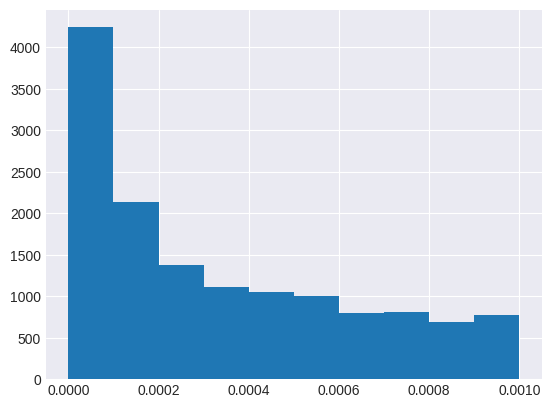

In [271]:
plt.hist(jumps[(jumps < 1e-3)])
plt.show()

In [233]:
pos = np.where(jumps > 20)[0]

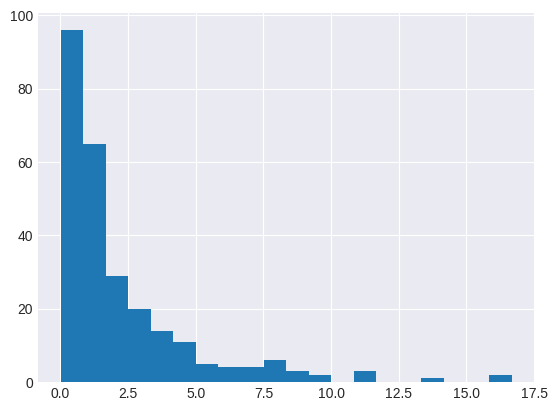

In [234]:
plt.hist(sim.t[pos[1:]] - sim.t[pos[:-1]], bins=20)
plt.show()

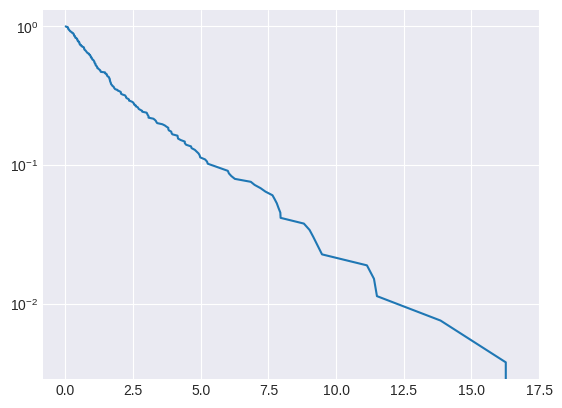

In [235]:
q_pos = np.sort(sim.t[pos[1:]] - sim.t[pos[:-1]])
plt.plot(q_pos[::-1], np.linspace(0, 1, num=len(q_pos)))
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [236]:
print((sim.t[pos[1:]] - sim.t[pos[:-1]]).mean(), ", ", (sim.t[pos[1:]] - sim.t[pos[:-1]]).std())

2.237094339595272 ,  2.7003165870233388


In [237]:
M_ = np.zeros_like(mgle)
M_[1:] = np.where(jumps > 20, dM, 0.0)
M_ = M_.cumsum()

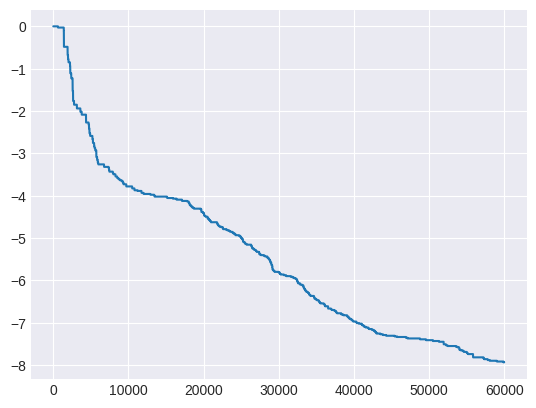

In [238]:
plt.plot(M_)
plt.show()

In [215]:
interpos = [jumps[0:pos[0]].sum()]
for p0, p1 in zip(pos[:-1], pos[1:]):
    interpos.append(jumps[(p0+1):p1].sum())

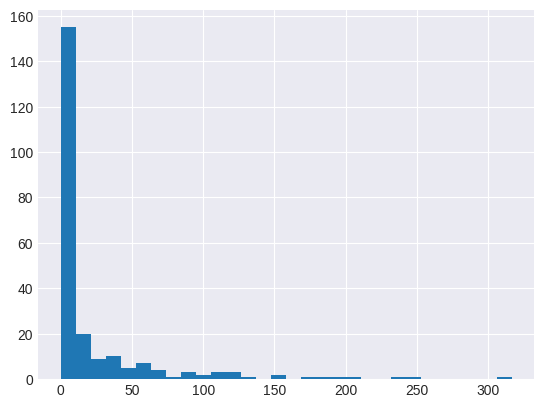

In [216]:
plt.hist(np.array(interpos), bins=30)
plt.show()

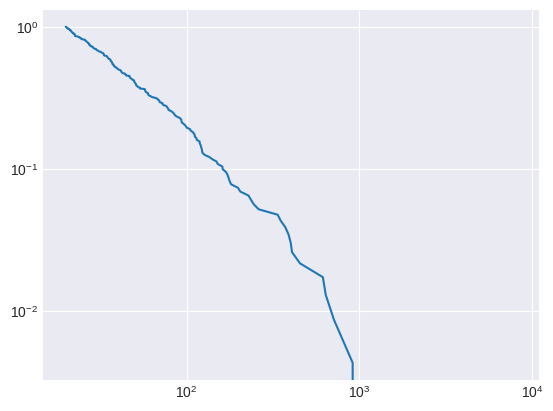

In [217]:
q_interpos = np.sort(interpos)
plt.plot(q[::-1], np.linspace(0, 1, num=len(q_interpos)))
plt.xscale('log')
plt.yscale('log')
plt.show()

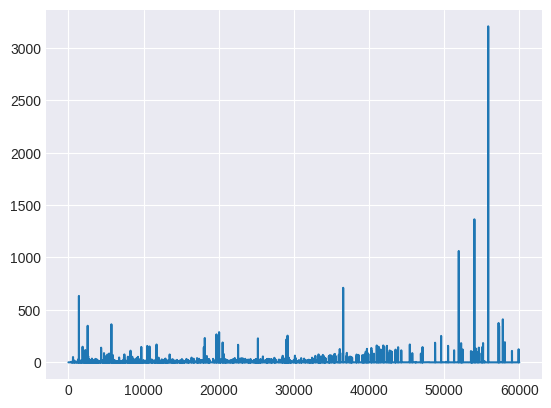

In [292]:
jumps_ = jumps[10:] + jumps[9:-1] + jumps[8:-2] + jumps[7:-3] + jumps[6:-4] + jumps[5:-5] + jumps[4:-6] + jumps[3:-7] + jumps[2:-8] + jumps[1:-9] + jumps[:-10]
plt.plot(jumps_)
plt.show()

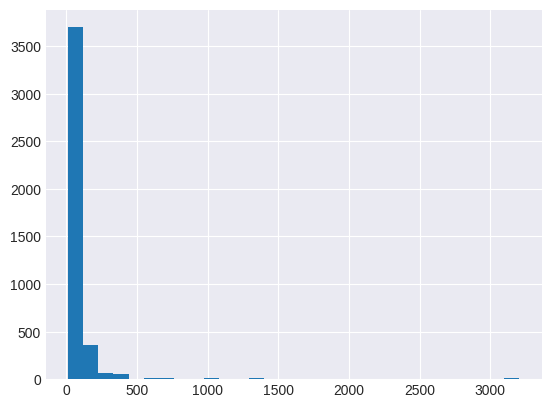

In [293]:
plt.hist(jumps_[jumps_ > 15], bins=30)
plt.show()

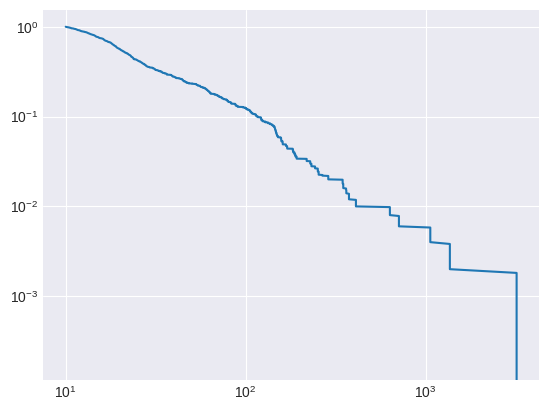

In [305]:
q = np.sort(jumps_[jumps_ > 10])
plt.plot(q[::-1], np.linspace(0, 1, num=len(jumps_[jumps_ > 10])))
plt.xscale('log')
plt.yscale('log')
plt.show()

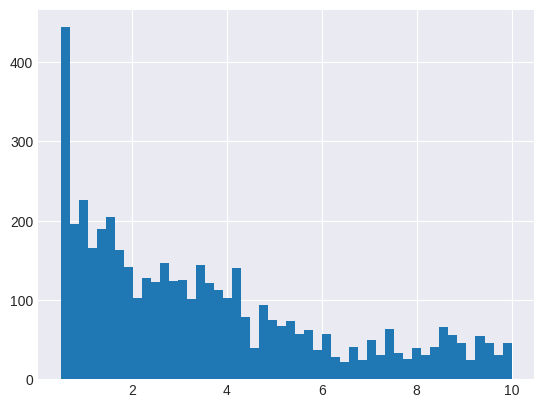

In [318]:
plt.hist(jumps_[(jumps_ > 0.5) * (jumps_ < 10)], bins=50)
plt.show()

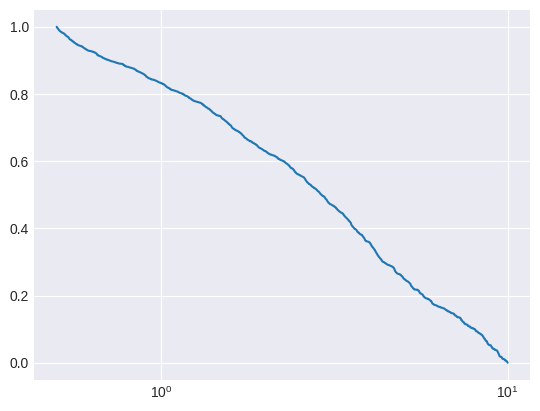

In [316]:
q = np.sort(jumps_[(jumps_ < 10) * (jumps_ > 0.5)])
plt.plot(q[::-1], np.linspace(0, 1, num=len(q)))
plt.xscale('log')
#plt.yscale('log')
plt.show()